In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PTA

from IPython.display import SVG, display

# Launch an ipyparallel cluster at the command line (inside the conda env with PTA installed)
# `ipcluster start --n=40 --cluster-id=PTA --daemonize`

ipyclient = ipp.Client(cluster_id="PTA")
print(len(ipyclient))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
50


In [2]:
sim = PTA.DemographicModel_2D_Temporal("2D-Tutorial")
print(sim.get_params())

------- PTA params - DemographicModel_2D_Temporal - (v.0.0.12) -----------------
2D-Tutorial          ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
10                   ## [2] [npops]: Number of populations undergoing co-demographic processes
4,4                  ## [3] [nsamps]: Numbers of samples for each populations
0                    ## [4] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
1000                 ## [5] [length]: Length in bp of each independent genomic region to simulate
100                  ## [6] [num_replicates]: Number of genomic regions to simulate
1                    ## [7] [generation_time]: Generation time in years
1                    ## [8] [body_size]: Body size per species (Modifies growth rate)
1e-09                ## [9] [recoms_per_gen]: Recombination rate within independent regions scaled per base per generation
1e-08                ## [10] [muts_per_

## Demonstrate setting parameters

In [3]:
sim.set_param("npops", 5)                      # Number of populations/species
sim.set_param("nsamps", [10,10])               # Historical and contemporary sample size (in diploid individuals)
sim.set_param("num_replicates", 100)           # Number of independent genomic regions to simulate per population (# loci)
sim.set_param("muts_per_gen", 0.0000001)       # Mutation rate per base per generation

## Generation time in years per generation
#sim.set_param("generation_time", 1)           # Can be one value, and all pops use the same generation time or
sim.set_param("generation_time", [1,2,2,3,1])  # a list of gen times, in which case must be exactly `npops` in length
                                               # e.g. one generation time per population

## Body size
#sim.set_param("body_size", 1)                 # Body size works the same way as generation time, either one value
sim.set_param("body_size", [1,2,2,3,4])        # or a list of values of length `npops`

## Ancestral Ne
#im.set_param("ne_ancestral", 100000)          # Ancestral Ne can take a fixed value or
sim.set_param("ne_ancestral", [10000, 1e6])    # a range as a list [min, max], which will sample uniform for each pop

## Recent population size change
##
## Within each simulation, growth rates per species (r_modern) are sampled from:
## r_modern ~ N(r_modern_mu + r_modern_alpha * bodysize, r_modern_sigma)
##
## Setting body_size to 0 will ignore the alpha term (growth rate unaffected by body size)
##
## All the r_modern_* parameters can be _fixed_ to one value or set to a range [min, max]
## which will be sampled uniformly within a given simulation. For each simulation, mu
## sigma, and alpha are retained and can be estimated from the data.
sim.set_param("r_modern_mu", [-0.2, 0])        # Mean of the growth rate distribution
sim.set_param("r_modern_sigma", [0, 0.1])      # Stdv of the growth rate distribution
sim.set_param("r_modern_alpha", [-0.01, -0.1]) # Term to scale growth rate by body size

print(sim.get_params())

------- PTA params - DemographicModel_2D_Temporal - (v.0.0.12) -----------------
2D-Tutorial          ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
5                    ## [2] [npops]: Number of populations undergoing co-demographic processes
10,10                ## [3] [nsamps]: Numbers of samples for each populations
0                    ## [4] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
1000                 ## [5] [length]: Length in bp of each independent genomic region to simulate
100,100,100,100,100  ## [6] [num_replicates]: Number of genomic regions to simulate
1.0,2.0,2.0,3.0,1.0  ## [7] [generation_time]: Generation time in years
1.0,2.0,2.0,3.0,4.0  ## [8] [body_size]: Body size per species (Modifies growth rate)
1e-09                ## [9] [recoms_per_gen]: Recombination rate within independent regions scaled per base per generation
1e-07                ## [10] [muts_per_

## Run 2 simulations by hand
`serial_simulate()` returns a list of jmsfs of length `nsims`

In [183]:
jmsfs_results = sim.serial_simulate(nsims=2)

  [####################] 100%  Finished 2 simulations in   0:00:01 | 
 

## Plot the 2D sfs
The default will sum each sfs bin across all `npops` species, creating an aggregated view

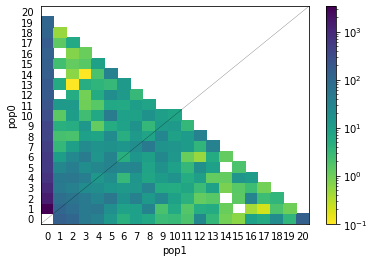

In [184]:
# Take the first jmsfs from the results list
first_jmsfs = jmsfs_results[0]
first_jmsfs.plot_2d_sfs()

## Run a batch of simulations

In [9]:
#!rm ./default_PTA/2D-Tutorial-SIMOUT.csv
nsims = 1000
sim.simulate(nsims=nsims, ipyclient=ipyclient)

    Generating 1000 simulation(s).
  [####################] 100%  Finished 1000 simulations in   0:01:03
 

## Plot the simulations in PC space

In [11]:
# Load the simulations and inspect the model parameters
# Any model parameter that is variable can be used to color the PCA to demonstrate
# how it impacts variation in the simulations
params, jmsfs = sim.load_simulations()
params

,zeta,zeta_e,r_modern_mu,r_modern_sigma,r_modern_alpha,r_moderns_mean,r_moderns_std,r_moderns_skewness,r_moderns_kurtosis,r_moderns_median,r_moderns_iqr,Ne_s_mean,Ne_s_std,Ne_s_skewness,Ne_s_kurtosis,Ne_s_median,Ne_s_iqr
0,0.351,2,-0.044,0.062,-0.085,-0.246,0.108,0.465,-0.857,-0.273,0.103,395447.2,341960.381,0.310,-1.782,229660.0,692629.0
1,0.233,2,-0.046,0.029,-0.057,-0.161,0.088,0.224,-0.862,-0.165,0.080,655881.0,301527.182,-0.552,-1.297,809940.0,434419.0
2,0.012,1,-0.041,0.041,-0.062,-0.171,0.042,-0.294,-1.177,-0.170,0.057,524153.0,343937.090,0.394,-1.786,308568.0,686769.0
3,0.722,4,-0.166,0.097,-0.011,-0.131,0.115,-0.693,-1.185,-0.055,0.158,404947.0,139559.374,-1.322,0.014,463290.0,61391.0
4,0.529,3,-0.024,0.009,-0.075,-0.210,0.078,0.013,-0.785,-0.198,0.057,418311.6,251432.176,0.810,-0.517,329085.0,169390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,0.129,1,-0.099,0.015,-0.051,-0.228,0.047,0.238,-0.558,-0.228,0.018,421629.0,167987.730,-0.258,-0.857,471290.0,135368.0
1051,0.156,1,-0.071,0.049,-0.043,-0.168,0.034,-0.085,-1.675,-0.161,0.065,484644.4,240814.053,0.923,-0.664,345157.0,233385.0
1052,0.855,5,-0.137,0.032,-0.024,-0.206,0.027,-0.037,-0.757,-0.203,0.019,675035.4,204455.241,0.141,-1.434,656458.0,324741.0
1053,0.285,2,-0.030,0.092,-0.011,0.014,0.034,1.081,-0.322,0.002,0.027,505896.8,199646.890,-0.144,-1.385,556461.0,291488.0


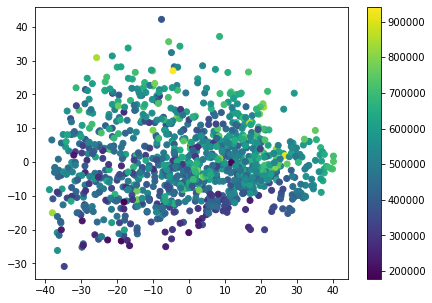

In [10]:
# Ne_s_mean is average ancestral Ne across all species
# This one shows weak structure based on this parameter
ax = sim.plot_sims_PCA(color_by="Ne_s_mean")

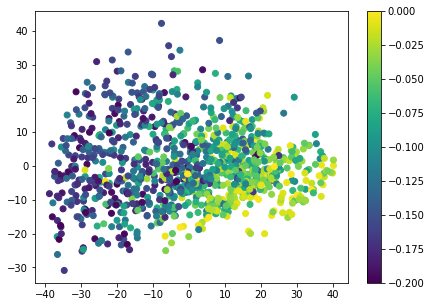

In [12]:
# r_modern_mu is the mean of the distribution that r_modern growth rates are sampled from for each simulation
# This one shows strong correlation
ax = sim.plot_sims_PCA(color_by="r_modern_mu")